In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.optimizers import Adam
import cv2
import keras


In [20]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset4/"
# if os.path.exists(wdr):
#     remove_tree(wdr)
# os.mkdir(wdr)
# copy_tree(train,wdr)
# copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['BT_CNN_model10', 'BT_CNN_model11', 'glioma', 'meningioma', 'notumor', 'pituitary']


In [21]:
work='./dataset4/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=200
ida=[200,200]
DIM=(idm,idm)

In [22]:
train_data_gen = IDG(rescale=1./255)
test_data_gen = IDG(rescale=1./255)

In [23]:
train_data = train_data_gen.flow_from_directory(
    directory=train,
    target_size=DIM,
    batch_size=4291,
    class_mode='categorical',  # Assuming the labels are categorical (one-hot encoded)
    shuffle=True
)

Found 8582 images belonging to 4 classes.


In [24]:
test_data = test_data_gen.flow_from_directory(
    directory=test,
    target_size=DIM,
    batch_size=1705,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 1705 images belonging to 4 classes.


In [25]:
train_data, train_labels = train_data.next()

In [26]:
len(train_data),len(train_labels)

(4291, 4291)

In [27]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [28]:
len(train_data),len(val_data),len(train_labels)

(3432, 859, 3432)

In [29]:
base_model = EfficientNetB7(input_shape=(idm, idm, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

In [30]:
custommodel = tf.keras.Sequential([
    base_model,
    Dropout(0.10),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.10),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.10),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.10),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.10),
    Dense(4, activation='softmax'),
], name="inception_cnn_model")

In [31]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
optmizer=Adam(learning_rate=0.001)
custommodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS,optimizer=optmizer)
custommodel.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2560)        0         
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 2560)              10240     
 chNormalization)                                                
                                               

In [32]:
EPOCHS = 25
history = custommodel.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/25
108/108 [==============================] - 566s 5s/step - loss: 1.4592 - train_acc: 0.3412 - val_acc: 0.6108 - f1_score: 0.3450 - val_loss: 1.3808 - val_train_acc: 0.2887 - val_val_acc: 0.5529 - val_f1_score: 0.1579
Epoch 2/25
108/108 [==============================] - 380s 4s/step - loss: 1.3238 - train_acc: 0.3616 - val_acc: 0.6444 - f1_score: 0.3700 - val_loss: 1.3642 - val_train_acc: 0.2736 - val_val_acc: 0.6100 - val_f1_score: 0.1246
Epoch 3/25
108/108 [==============================] - 373s 3s/step - loss: 1.2867 - train_acc: 0.3607 - val_acc: 0.6563 - f1_score: 0.3704 - val_loss: 1.3089 - val_train_acc: 0.3329 - val_val_acc: 0.6467 - val_f1_score: 0.2233
Epoch 4/25
108/108 [==============================] - 370s 3s/step - loss: 1.2729 - train_acc: 0.3773 - val_acc: 0.6701 - f1_score: 0.3852 - val_loss: 1.2918 - val_train_acc: 0.3388 - val_val_acc: 0.6681 - val_f1_score: 0.2429
Epoch 5/25
108/108 [==============================] - 797s 7s/step - loss: 1.2645 - train_ac

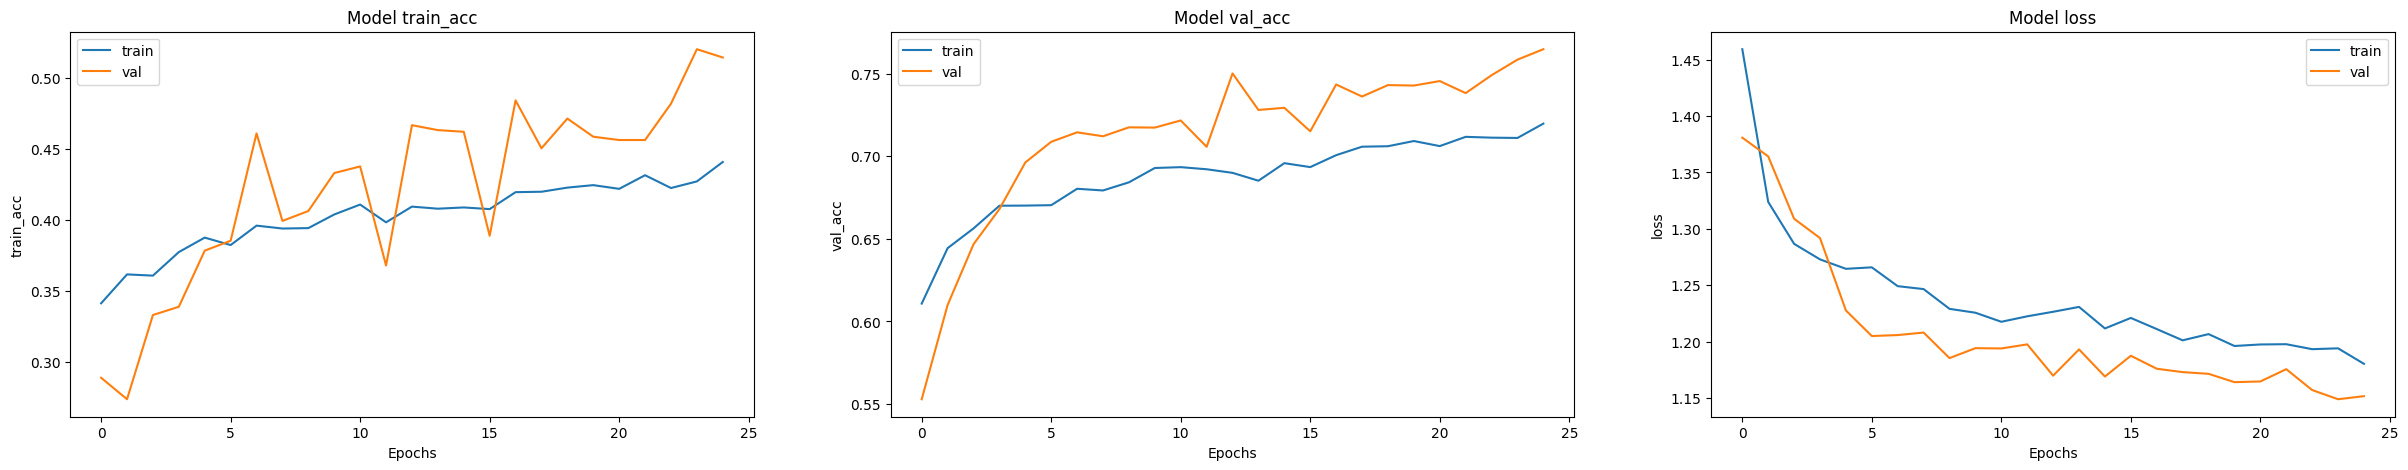

In [33]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [1]:
test_scores=custommodel.evaluate(test_data,train_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

NameError: name 'custommodel' is not defined

In [ ]:
pred_labels=custommodel.predict(test_data)

In [ ]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(train_labels,pred_labels,target_names=classes))